In [15]:
# import necessary libraries 
import os 
os.sys.path.insert(0, 'E:\\dev\\packages')

from tkinter import Tcl
import matplotlib.pyplot as plt 
import numpy as np

from PIL import Image
from scipy import ndimage as nd
import json

from tqdm import tqdm 

import ipywidgets as widgets

from skimage import img_as_ubyte

from proUtils import utils
from proUtils.notebook import vis

### creating a list of fibrosis points including their value and coordinates 


In [10]:
# reading a file for example 
roi_path  = "E:\\Data\\sam_data\\new\\MD_1264_A9_Z0.0mm_Z3.3mm\\roi\\600-900x1350-1650x2350-2650"
vol = utils.load_roi(roi_path, check_blank=True)
vol = nd.median_filter(vol, size=2)
# vis.interactive_visualize(vol)

In [17]:
bin_th = 55
th_vol = vol < bin_th
thm_vol = nd.binary_fill_holes(th_vol, np.ones((3,3,3)))
thm_vol = nd.binary_closing(th_vol, np.ones((2,2,2)))
# vis.interactive_visualize(thm_vol)

In [12]:
inth_vol = ~th_vol

inth_vol = nd.binary_closing(inth_vol, np.ones((3,3,3)))
inth_vol = nd.binary_fill_holes(inth_vol, np.ones((2,2,2)))

# vis.interactive_visualize(inth_vol)


In [16]:
vis.interactive_visualize(utils.combine_ndarrays(vol, img_as_ubyte(thm_vol), img_as_ubyte(inth_vol), space_btwn=10))

interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

In [18]:
dt3d = nd.distance_transform_edt(inth_vol)
msk = dt3d > 8
fib_vol = msk * dt3d
vis.interactive_visualize(fib_vol, cmap='jet')

interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

In [12]:
def sliding_window_max3d(volume, window_size, step_size):
    max_pixels = []
    depth, height, width = volume.shape
    fig, ax = plt.subplots()
    ax.imshow(volume[0], cmap='gray')
    for z in range(0, depth - window_size[0] + 1, step_size[0]):
        for y in range(0, height - window_size[1] + 1, step_size[1]):
            for x in range(0, width - window_size[2] + 1, step_size[2]):
                window = volume[z:z+window_size[0], y:y+window_size[1], x:x+window_size[2]]
                max_pixel = np.max(window)
                if max_pixel > 0:
                    max_pixel_pos = np.unravel_index(np.argmax(window), window.shape)
                    max_pixel_pos = (max_pixel_pos[2]+x, max_pixel_pos[1]+y, max_pixel_pos[0]+z)
                    max_pixels.append((max_pixel, max_pixel_pos))
                    rect = plt.Rectangle((x, z), window_size[2], window_size[0], fill=False, edgecolor='r', lw=1)
                    ax.add_patch(rect)
                    ax.plot(max_pixel_pos[0], max_pixel_pos[2], 'ro', markersize=2)
    plt.show()
    return max_pixels

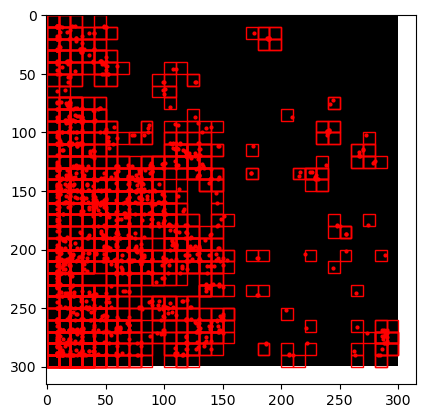

In [13]:
max_pixels3d = sliding_window_max3d(fib_vol, (10, 10, 10), (10, 10, 10))

In [15]:
from mpl_toolkits.mplot3d import Axes3D

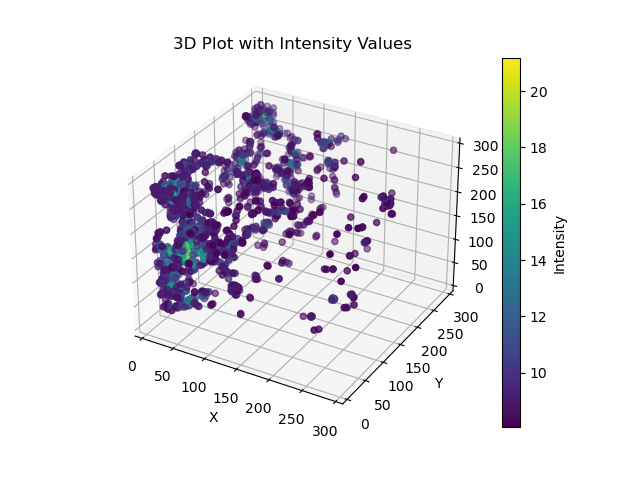

In [16]:
# Extract coordinates and intensity values
coordinates = np.array([point[1] for point in max_pixels3d])
intensity = np.array([point[0] for point in max_pixels3d])

# Create figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point with intensity as color
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=intensity, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot with Intensity Values')

# Add color barl
cbar = plt.colorbar(scatter)
cbar.set_label('Intensity')

# Show the plot
plt.show()